<a href="https://colab.research.google.com/github/choiy5/AI-in-Physics-tutorial-STEM/blob/main/Final_ver_AI_in_Physics_ML_STEM_Defect.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **AI in Physics Hands-on Tutorial: Identifying point defects in STEM images of MoS2**

이번 세션에서는 딥러닝을 이용한 이미지 분석을 물리학, 그 중에서도 고체 물리에서 어떻게 사용할 수 있는지 보겠습니다. 구체적으로, MoS2를 찍은 STEM 이미지에서 defect들을 찾아내는 딥러닝 모델을 만들고 학습시킨 후, 평가해보도록 하겠습니다.


---


**딥러닝에서 데이터 셋 (이미지 셋)의 역할**:

이미지 셋은 원리 설명이 없는 기출 문제집이라고 볼 수 있습니다. 모델은 이 기출문제집의 문제들을 풀고 답을 맞추면서 문제들이 테스트하고자 하는 개념을 배우게 됩니다.

(이미지=문제=Q.다음 이미지에서 defect들의 위치는?)

이 개념을 모델에게 잘 학습시켜서, 한번도 보지 않은 새로운 문제들도 잘 맞출 수 있게 하는 것이 목표입니다.


---


**STEM 이미지 딥러닝에서의 특이점**:

모델이 모든 종류의 defect에 대해서 한꺼번에 학습시키는 것보다, defect 종류별로 따로 학습을 하는게 더 효율적이라고 보고되고 있습니다. 문제집 비유를 사용하면, 문제 하나 당 한 개의 개념만 테스트하도록 문제를 만듭니다. 따라서 학습할 개념이 A, B 2가지면 A를 테스트하는 문제들로만 이루어진 문제집, B를 테스트하는 문제들만 있는 문제집, 총 2권의 문제집이 필요합니다.

우리가 테스트할 MoS2는 single-sulfur vacancy (1vac), double-sulfur vacancy (2vac), 총 2종류의 defect이 있기 때문에, 1vac용과 2vac용 이미지 세트 2개가 있습니다. 각 이미지 세트를 이용해서 두 번 학습을 해야 하는데, **먼저 2vac에 대해 딥러닝을 한 후, 1vac에도 적용해보겠습니다.**

# **0. 환경 설정 하기**

먼저, 구글 드라이브를 코랩에 마운트합니다.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


파이썬, 텐서플로우, 케라스 등 대부분 필요한 것들은 코랩에 이미 설치가 되어 있지만, 간혹 가다 없는 것은 !pip install을 이용해서 설치할 수 있습니다.

코랩어 설치되어 있지 않은 pickle5 모듈(피클되어 있는 학습 데이터를 원래 형태로 변환하기 위해)과 tifffile 라이브러리(학습 및 테스트 tiff 이미지들을 디스플레이하기 위해)를 설치합니다.

In [ ]:
# To load & unpickle the train & test files, which are provided in stem_tutorial as pickle files
!pip3 install pickle5

# Used to read in and visualize tiff images
!pip3 install tifffile

     |████████████████████████████████| 133kB 3.9MB/s 
  Created wheel for pickle5: filename=pickle5-0.0.11-cp36-cp36m-linux_x86_64.whl size=218608 sha256=dcc711abaa4e86d532833bf1bec0165eb424ff40dfc9068b9ac08406601a7f86
  Stored in directory: /root/.cache/pip/wheels/a6/90/95/f889ca4aa8b0e0c7f21c8470b6f5d6032f0390a3a141a9a3bd
Successfully built pickle5


다음과 같이 필요한 케라스 모듈, 파이썬 라이브러리 및 마운트 한 구글 드라이브의 `/stem_tutorial` 안 파이썬 스크립트 `tutorial_functions`를 불러오겠습니다.


In [ ]:
# Keras with Tensorflow backend
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Reshape, Activation
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint

# Import necessary python libraries
# os: Module to interact with the operating system.
# Will need to call in train files from Google drive.
import os

# pickle5: to unpickle the train files in the form of pickle files
import pickle5 as pickle

# matplotlib.pyplot: Useful for plotting & visualizing data
import matplotlib.pyplot as plt

# NumPy: Numerial Python. 파이썬의 고성능 과학 계산용 패키지.
# Matrix, vector 같은 array 연산을 빠르고 효율적으로 함.
# 딥러닝 모델은 이미지들을 numpy array로 변환한 포맷으로 학습.
import numpy as np

# 구글 드라이브 안 파이썬 스크립트에서 정의된 함수들 불러 오기
import sys
sys.path.insert(0, '/content/gdrive/MyDrive/stem_tutorial/')
from tutorial_functions import *

# **1. 학습 데이터 불러오기**

학습 데이터를 불러오기 위한 `get_data()` 메소드를 정의하겠습니다. 설정할 변수는 vac_type (defect 종류)로, 1vac이나 2vac으로 설정합니다.

In [ ]:
# When using this function, set vac_type="1vac" or "2vac"
def get_data(vac_type):
  '''
  Loads and unpickles the train & test files and returns numpy arrays
  '''

  data_dir = '/content/gdrive/MyDrive/stem_tutorial/train_data/train_' + vac_type

  train_f = os.path.join(data_dir, "train_" + vac_type + ".p")
  train_data = load_data(train_f)
  print("Finished loading the train data.")
  
  train_image = np.asarray([train_data[i][0] for i in range(len(train_data))], dtype=np.float32)
  train_label = np.asarray([train_data[i][1] for i in range(len(train_data))], dtype=np.float32)

  print("Finished saving the train data set into image & label numpy arrays.")

  val_f = os.path.join(data_dir, "val_" + vac_type + ".p")
  val_data = load_data(val_f)
  print("Finished loading the validation set.")

  val_image = np.asarray([val_data[i][0] for i in range(len(val_data))], dtype=np.float32)
  val_label = np.asarray([val_data[i][1] for i in range(len(val_data))], dtype=np.float32)

  print("Finished saving the val data set into image & label numpy arrays.")
  
  return (train_image, train_label), (val_image, val_label)

이제 학습에 사용할 이미지 셋들을 가지고 오겠습니다. 학습 데이터는 /stem_tutorial/train_data안에 있는데, 세부 분류는 아래와 같습니다.

1. train_1vac: Single S-vacancy 찾는 학습을 위한 데이터 셋
  *   train_1vac.p (train set=학습을 위한 기출문제)
  *   val_1vac.p (validation set=학습 도중 잘 학습하고 있나 체크하기 위한 대단원 평가 문제)
2. train_2vac: Double S-vacancy 찾는 학습을 위한 데이터 셋
  *   train_2vac.p 
  *   val_2vac.p

하나의 train.p 파일 안에는 128 x 128 [px] 사이즈 이미지-라벨 pair들이 6888장 있고, val.p 파일 안에는 379장의 이미지-라벨 pair이 있습니다.

`get_data()`을 이용해 학습 데이터를 가져옵니다. 먼저 double S-vacancy (2vac)에 대한 데이터셋을 가지고 와서 학습을 진행하겠습니다. (시간이 좀 걸립니다.)

In [ ]:
vac_type = "2vac"
(train_image, train_label), (val_image, val_label) = get_data(vac_type)

Finished loading the train data.
Finished saving the train data set into image & label numpy arrays.
Finished loading the validation set.
Finished saving the val data set into image & label numpy arrays.


`(train_image, train_label)` pair은 0부터 (이미지 개수-1) 까지 indexing 되어서 들어 있기 때문에, 인덱스 n=0-6887 사이의 정수로 설정해서 해당 이미지와 라벨을 시각할 수 있습니다. 마찬가지로, `(val_image, val_label)` pair도 n=0-378까지 인덱싱 되어 있습니다.

왼쪽이 학습에 사용할 이미지이고, 오른쪽이 defect들의 위치를 표시한 라벨 이미지입니다.

100th image in 2vac train set


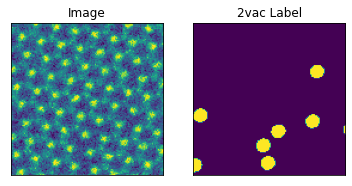

90th image in 2vac train set


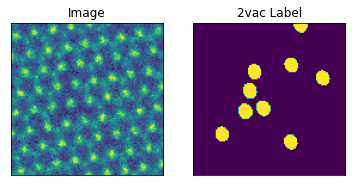

In [ ]:
n = 100 # (0<=n<6888)
visualize_data(train_image, train_label, n, vac_type)

m = 90 # (0<=m<379)
visualize_data(val_image, val_label, m, vac_type)

# **2. 모델 정의**

아래의 `model_fcn()` 함수를 이용해서 사용할 모델을 정의해보도록 하겠습니다.

들어가는 변수의 종류는 5가지입니다.

(1) input_img: 이미지의 모양. Input(shape=(width, height, depth))의 형태를 가집니다. 이미지는 넓이, 높이 외에도 색을 가진 경우 두께라는 세번째 변수가 있는데, RGB 이미지의 경우에는 depth=3, 우리가 사용하는 흑백 이미지의 경우에는 depth=1입니다.

(2) kernel: 이미지에서 중요한 feature들을 추출할 때 사용하는 윈도우 사이즈. 

(3) N: (이미지가 정사각형이라는 가정하에) 이미지 변의 길이.

(4) n_filters: 각 레이어의 필터 개수에 공통으로 곱해지는 수이고, 레이어 당 필터의 개수를 더 쉽게 조절하기 위해 있습니다. 기본값은 4입니다.

(5) nb_classes: 모델이 학습하는 feature의 가지수. 앞서 언급한 대로 STEM TMDC 이미지 분석에서는 defect의 종류별로 나눠서 학습하기 때문에, 매 학습 세션당 defect인지 아닌지에 대해서 학습을 합니다. 따라서, defect의 종류와 무관하게 항상 2로 설정해야 합니다.


In [ ]:
# Inputs:
# (1) input_img = shape of the input image (assume square image)
# (2) kernel = the window size to extract the important features in input_img
# (3) N = image size
# (4) n_filters = common factor to multiply # of channels in each layer
# (5) nb_classes: # of classes for the model to distinguish. This value is always 2 (defect vs. non-defect)

def model_fcn(input_img, N, kernel, n_filters=4, nb_classes=2):
  '''
  Returns an fcn model
  '''
  # Convolution
  x = Conv2D(2*n_filters, kernel, activation='relu', padding='same')(input_img)
  x = MaxPooling2D((2,2), padding = 'same')(x)
  x = Conv2D(4*n_filters, kernel, activation='relu', padding='same')(x)
  x = MaxPooling2D((2,2), padding='same')(x)
  x = Conv2D(8*n_filters, kernel, activation='relu', padding='same')(x)
  x = MaxPooling2D((2,2), padding='same')(x)
  
  # Deconvolution
  x = Conv2D(8*n_filters, kernel, activation='relu', padding='same')(x)
  x = UpSampling2D((2,2))(x)
  x = Conv2D(4*n_filters, kernel, activation='relu', padding='same')(x)
  x = UpSampling2D((2,2))(x)
  x = Conv2D(2*n_filters, kernel, activation='relu', padding='same')(x)
  x = UpSampling2D((2,2))(x)
  
  # Final 
  x = Conv2D(nb_classes, kernel, activation='linear', padding='same')(x)
  # 1x1 convolution layer to do the classification task (defect or atom).
  # Note: There is no dense layer, hence "fully-convolutional" neural network
  x = Conv2D(nb_classes, (1,1), activation='linear', padding='same')(x)
  x = Reshape((N, N, nb_classes))(x)
  
  # Activation function (활성함수)
  output = Activation('softmax')(x)

  return Model(input_img, output)

사용할 이미지 사이즈와 커널 사이즈, 그리고 n_filters를 정하겠습니다. (*필터 개수가 많으면 그만큼 더 복잡하고 어려운 feature들도 이미지에서 더 잘 추출할 수는 있지만, 
필터 개수에 비례해 학습력이 항상 좋아지는 것은 아닙니다.)

In [ ]:
# Image dimension (assume square image)
N = 128

# Shape of the image
input_image = Input(shape=(N,N,1))

# Kernel size
kernel = (7,7)

# Common factor to multiply number of filters in each layer
n_filters = 4

위에서 정의한 함수 `model_fcn()`을 이용해서 `model`이라는 이름의 모델을 만들겠습니다.

In [ ]:
# Create an instance of the model
model = model_fcn(input_image, N, kernel, n_filters)

이제 `compile()`을 이용해서 모델을 기계가 이해할 수 있도록 컴파일 합니다. 설정해야 할 몇 가지 변수는 아래와 같습니다.

(1) optimizer: 학습 속도 조절하는 수리 계획.
(https://gomguard.tistory.com/187)

(2) loss: 모델의 예측과 실제 답 사이의 오차를 수치화하는 손실 함수.

(3) metrics: 학습 시 중점적으로 모니터링할 지표. 대표적인 예로 accuracy가 있습니다.

In [ ]:
# Compiles the model using an optimizer, a loss function, and metrics to monitor
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

만든 모델에 `summary()`를 이용해서 모델의 구조를 출력해서 볼 수 있습니다. 또한 `plot_model()`을 이용하면 모델의 구조를 시각화해서 볼 수 있습니다.

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 128, 8)       400       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 8)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 16)        6288      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        25120     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 32)        0     

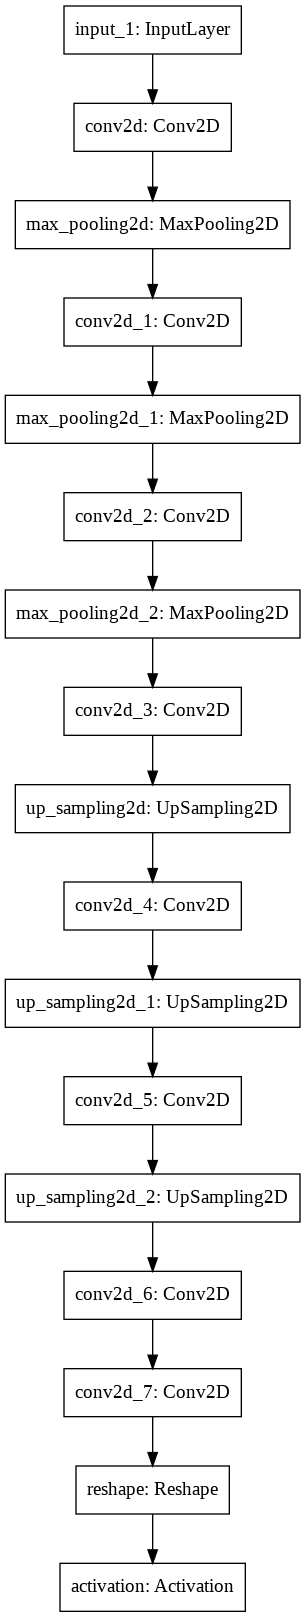

In [ ]:
# Provides a structure of the model
model.summary()

# Visualizes the structure of the model
plot_model(model, to_file='fcn_model.png')

*Optional: 다른 모델 사용하기

`model_fcn()`의 구조를 바꾸거나 (레어의 종류와 개수, 활성함수 등), keras에서 구현된 모델들(ex. ResNet50, VGG16)을 직접 다운 받아서 사용할 수도 있습니다. 아래는 케라스 모델을 다운받는 방법입니다.

In [ ]:
'''
Imports ResNet50 from Keras
'''
from keras.applications.resnet50 import ResNet50
# load model
model_res = ResNet50()
# summarize the model
model_res.summary()
plot_model(model_res, to_file='modelres.png')

In [ ]:
'''
Imports VGG16 from Keras
'''
from keras.applications.vgg16 import VGG16

# load model and specify a new input shape for images and avg pooling output
new_input = Input(shape=(640, 480, 3))
vmodel = VGG16(include_top=False, input_tensor=new_input, pooling='avg')
vmodel.summary()
plot_model(vmodel, to_file='VGG16_model.png')

# **3. 모델 학습**


이제 `fit()`  메소드를 사용해서 학습을 위한 이미지와와 라벨 이미지들을 정의된 FCN 모델에 주입하고 학습을 진행합니다.

fit()에 들어가는 기본적인 변수는 아래와 같습니다.

(1) **train_image**: 위에서 불러들인 학습용 이미지 (기출문제)

(2) **train_label**: 위에서 불러들인 학습용 이미지에 대한 vacancy 위치를 표시한 라벨 (기출문제 답)

(3) **batch_size**: 몇 개의 문제를 풀고 답을 맞출지를 의미. 즉, batch_size 개수의 이미지에 대해 모델이 vacancy들의 위치를 예측하고, 한꺼번에 라벨 이미지들과 비교해서 답을 맞춥니다. 그렇게 답을 맞추고 네트워크의 가중치를 갱신합니다.

(4) **epochs**: 주어진 학습용 이미지 세트 (기출문제집)를 몇 번 반복학습 하는지를 의미. epoch이 1이면 문제집을 한번만 푸는 것이고, 10이면 10번 반복해서 풉니다. 같은 문제를 반복해서 풀어도 학습이 일어나지만, 너무 많이 풀면 문제를 통한 진정한 학습보다는 자칫 문제집 문제와 답을 외우게 되는 것처럼, epoch이 크면 클수록 overfitting의 위험도 늘어납니다.

(5) **validation data**: 모델이 학습하는 도중에 얼마나 잘 배우고 있는지 평가하기 위한 이미지셋 (기출 문제집 단원마다 있는 대단원 평가파트). 풀었던 기출문제들을 외우기 시작했는지 (overfitting이 일어나기 시작하는지)를 체크할 때 사용할 수 있습니다. 위에서 불러들인 (val_image, val_label)을 넣습니다.

(Optional) (6) **callbacks**: 학습할 때 좀 더 편리할 수 있도록 사용자가 추가적인 기능들을 설정하는 곳입니다.

먼저, 학습할 때 좀 더 편리하게 할 수 있도록 사용자 지정 callbacks를 만들겠습니다.

(1) `early_stopping_callback`: validation set에서의 loss(대단원 평가 때 모델이 내놓은 답들의 오차)를 모니터링하면서 모델이 데이터 셋에 overfitting(학습 문제들을 외워서 푸는 것) 하기 전에 학습을 중단시킵니다.

(2) `model_checkpoint_callback`: 매 epoch (데이터 셋 한번 학습)이 끝난 후 자동으로 모델을 저장합니다.

In [ ]:
# Stops training if the validation loss does not improve for 3 epochs
# Prevents overfitting
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=3)

# Saves the model after each epoch
model_checkpoint_callback = ModelCheckpoint(
    filepath= '/content/gdrive/MyDrive/stem_tutorial/save_directory/sv2' + '/model_sv2.{epoch:03d}-val_loss{val_loss:.3f}.h5',
    monitor='val_loss',
    mode='auto',
    save_best_only=False)

# Callback list that incorporates the above two settings
my_callbacks = [early_stopping_callback, model_checkpoint_callback]

이제 `model.fit()`을 이용해서 학습 시킵니다. 

In [ ]:
# Trains the model
model.fit(train_image, train_label, batch_size=32, epochs=2, validation_data=(val_image, val_label), callbacks=my_callbacks, verbose=1)

Epoch 1/2
 17/216 [=>............................] - ETA: 8:55 - loss: 0.5488 - accuracy: 0.7781

KeyboardInterrupt: ignored

# **4. 학습한 모델 평가**

이제 저장한 모델을 하나씩 불러들여서 테스트 이미지에 대해서 얼마나 vacancy를 잘 찾아내고 구분하는지 평가하겠습니다.

`../stem_tutorial/test_images/` 안에는 학습된 모델을 테스트하기 위한 이미지가 아래와 같이 나누어져 있습니다.

*   `128_simulated_image`: 0-3번 폴더 안 각각에 1장씩, 총 4장의 시뮬레이션 이미지가 있고, 0부터 3 순으로 노이즈가 더 많습니다.
*   `128_noisy_real_image`: 보정을 거의 하지 않은 실제 이미지 2장이 있습니다.

# **4a. 2vac에 학습한 모델 평가**

먼저 저장한 모델 하나를 `load_model()`을 이용해서 불러들이겠습니다. 시간상의 관계로, 이번 튜토리얼에서는 미리 학습시켜 놓은 모델을 이용하겠습니다. 튜토리얼과 동일한 모델로, 서울대 서버에서 2vac에 대해 5 epoch 동안 학습 시켰던 모델입니다.

*Optional: 코랩에서 학습이 완료된 후 저장된 모델을 골라서 사용하려면, #된 셀에서 #를 지우고 사용하면 됩니다.

In [ ]:
# Loads a pre-trained model
sv2_trained_model = '/content/gdrive/MyDrive/stem_tutorial/pretrained_models/sv2_saved_models/model_sv2.005-val_loss0.022.h5'
sv2_loaded_model = load_model(sv2_trained_model)

In [ ]:
# *Optional: 학습이 완료된 후 저장된 모델을 골라서 사용하려면,
# sv2_trained_model = '/content/gdrive/MyDrive/저장한폴더위치/모델이름'
# Ex. '/content/gdrive/MyDrive/stem_tutorial/save_directory/sv2/model_sv2.002-val_loss0.089.h5'
# sv2_loaded_model = load_model(sv2_trained_model)

**시뮬레이션 이미지에 테스트**

시뮬레이션 이미지 한 장을 불러와서 테스트합니다.

아래 `evaluate_model()`을 이용해서 테스트 이미지에 대해 모델이 어떻게 vacancy들의 위치를 예측하는지 보고, 실제 vacancy 위치들과 비교해 보겠습니다.

설정해야 하는 변수는 세 가지 입니다.

(1) `test_vac_type = "2vac"` 또는 `"1vac"`. 테스트 하고자 하는 vacancy 종류.

(2) `test_image_type = "simulated"` 또는 `"noisy_real"`. 테스트 이미지 종류.

(3) `test_image_index = "simulated"`는 `0-3` 중에서 선택, `"noisy_real"`은 `0-1` 중에서 선택.

(4) `model`: 테스트 하고자 하는 모델. 메모리에서 가지고 온 모델을 사용하려고 하면 `"sv2_loaded_model"`로 설정합니다.

시뮬레이션 이미지 몇 장에 대해 테스트 해보겠습니다. (모든 이미지들에 대한 테스트 결과는 `/stem_tutorial/evaluation_results/` 안에 있습니다.

strides: (32, 32)
Model is currently identifying where the defects are...
Preparing to show the model's prediction...


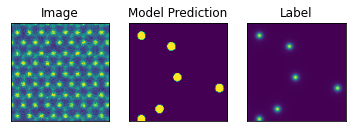

In [ ]:
# Evaluates the loaded model for the 0th simulated image (least amount of noise)
evaluate_model(test_vac_type="2vac", test_image_type="simulated", test_image_index=0, model=sv2_loaded_model)

strides: (32, 32)
Model is currently identifying where the defects are...
Preparing to show the model's prediction...


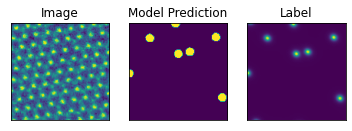

In [ ]:
# Evaluates the loaded model for the 3rd simulated image (greatest amount of noise)
evaluate_model(test_vac_type="2vac", test_image_type="simulated", test_image_index=3, model=sv2_loaded_model)

육안으로도 구분하기 비교적 수월한 2vac 에 대해서 모델은 모든 2vac들을 잘 찾아냅니다. 

**실제 이미지에 테스트**

이번에는 실제 이미지 두 장으로 모델을 테스트하겠습니다. 시뮬레이션 이미지에 비해 노이즈도 좀 더 많고, 특히 렌즈의 aberration으로 인해 원자들이 완벽한 원이 아닌 것을 볼 수 있습니다.

strides: (32, 32)
Model is currently identifying where the defects are...
Preparing to show the model's prediction...


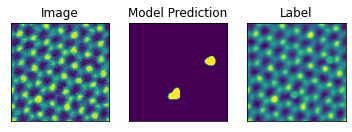

In [ ]:
# Evaluates the model for the 0th real image
evaluate_model(test_vac_type="2vac", test_image_type="noisy_real", test_image_index=0, model=sv2_loaded_model)

strides: (32, 32)
Model is currently identifying where the defects are...
Preparing to show the model's prediction...


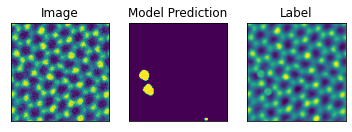

In [ ]:
# Evaluates the model for the 1st real image
evaluate_model(test_vac_type="2vac", test_image_type="noisy_real", test_image_index=1, model=sv2_loaded_model)

보는 바와 같이, 2vac의 위치를 대체적으로 잘 찾기는 했지만, 예측한 2vac들의 모양이 찌그러진 형태입니다. 이는 모델이 이미지 분석을 할 때 픽셀 단위로 한 후, defect으로 예측한 픽셀들을 노란색으로 표시해서 보여주기 때문입니다.

학습 과정에서 보지 못했던 feature들이 실제 이미지에 존재하는 만큼, 예측한 vacancy의 모양도 조금 일그러져 있습니다. 실제 이미지에도 시뮬레이션 이미지만큼 정확하게 defect들을 찾고 표시하기 위해서는, 더 많은 양과 더 좋은 퀄리티의 데이터가 필요합니다. 여기에서 데이터의 퀄리티는, 학습 이미지의 다양성을 일컫습니다 (다양한 종류와 레벨의 노이즈, 이미지가 틀어진 각도 등등). 이 부분은 뒤에서 AIMS 팀의 발표에서 더 자세하게 나올 예정입니다.

**시뮬레이션 이미지에 테스트**